## ML Model for Attack prediction

# LSTM
### Train the model

In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Load your data
df = pd.read_csv('./udp_commands.csv')

# Preprocessing
df['Attack Type'], df['Message'] = zip(*df['Command'].apply(lambda cmd: (cmd.split(",")[0].split(": ")[1], cmd.split(",")[1].split(": ")[1])))
df.drop(columns=['Command'], inplace=True)

# Convert Time to a numerical feature (e.g., timestamp)
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds

# Encode categorical data (Host IP and Message)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['Host IP', 'Message']]).toarray()
print("Number of features after encoding Host IP and Message:", encoded_features.shape[1])

# Scale numeric features (Time and Destination Port)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Time', 'Destination Port']])
print("Number of scaled features (Time and Destination Port):", scaled_features.shape[1])

# Combine all features
features = np.concatenate([scaled_features, encoded_features], axis=1)
print("Total number of features after combining:", features.shape[1])

# Convert categorical labels to one-hot encoding for the target
label_encoder = OneHotEncoder()
labels = label_encoder.fit_transform(df['Attack Type'].values.reshape(-1, 1)).toarray()

# Prepare time series data with new time_steps
time_steps = 50  # Using 50 past records to predict the next one
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_dataset(features, labels, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the number of features in each input sequence
print("Number of features per time step in X_train:", X_train.shape[2])



# Build the LSTM model with more complexity
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512))
model.add(Dense(512, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Setting up EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model saved by ModelCheckpoint
from keras.models import load_model
model = load_model('best_model_lstm.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy * 100:.2f}%")


C:\Users\Rugved Chavan\AppData\Local\Temp\ipykernel_67808\1801171530.py:19: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Time'] = df['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds


Number of features after encoding Host IP and Message: 48
Number of scaled features (Time and Destination Port): 2
Total number of features after combining: 50
Number of features per time step in X_train: 50
Epoch 1/100
187/190 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.9295
Epoch 1: val_loss improved from inf to 0.46886, saving model to best_model_lstm.h5
190/190 [==============================] - 7s 21ms/step - loss: 0.3073 - accuracy: 0.9297 - val_loss: 0.4689 - val_accuracy: 0.8235
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9650
Epoch 2: val_loss did not improve from 0.46886
190/190 [==============================] - 3s 17ms/step - loss: 0.1615 - accuracy: 0.9650 - val_loss: 0.5154 - val_accuracy: 0.8182
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9746
Epoch 3: val_loss improved from 0.46886 to 0.28180, saving model to best_model_lstm.h5
190/190 [===========

### Validation Metrics

Test loss: 0.25247788429260254
Test accuracy: 94.30%
30/30 [==============================] - 1s 8ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.98      0.97      0.97       202
           2       0.97      0.95      0.96       682
           3       0.00      0.00      0.00         6
           4       0.61      1.00      0.76        51

    accuracy                           0.94       948
   macro avg       0.51      0.58      0.54       948
weighted avg       0.94      0.94      0.94       948


Confusion Matrix:
 [[  0   0   7   0   0]
 [  0 195   5   0   2]
 [  0   3 648   0  31]
 [  0   1   5   0   0]
 [  0   0   0   0  51]]
Precision: 0.5123
Recall: 0.5831
F1-Score: 0.5381


c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugv

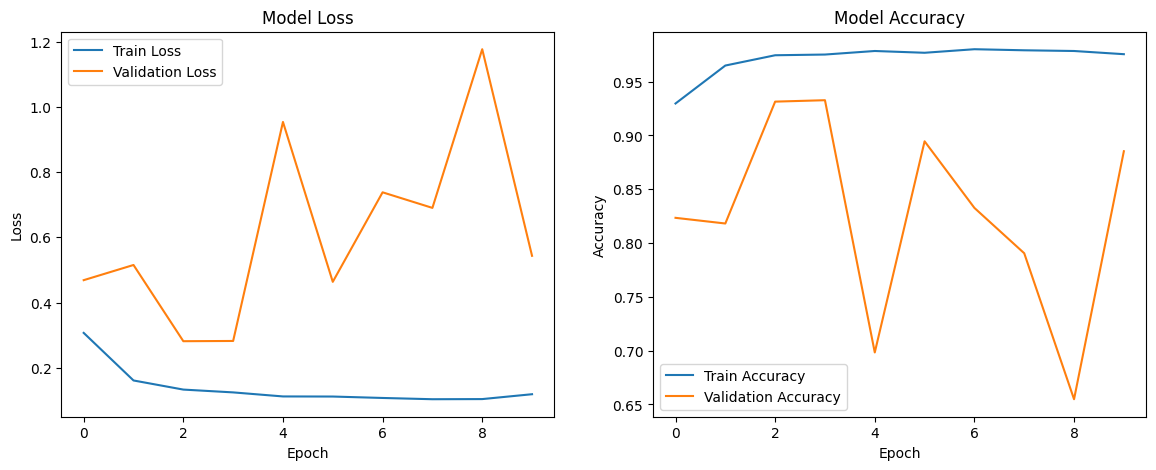

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Load the best model if not already loaded
model = load_model('best_model_lstm.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Predict classes with the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(true_classes, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:\n", cm)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plotting the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#### Test the model on few samples

In [70]:
import pandas as pd
from io import StringIO
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from keras.models import load_model

# Assuming you have a saved model, or it is loaded in the environment
# model = load_model('your_model.h5')  # Uncomment this if you need to load a saved model

# Sample test dataset provided as a string
data = """Time,Command,Host IP,Destination Port
2024-04-17 23:59:42,"attack type: normal - no attack, message: left",192.168.42.170,21612
2024-04-17 23:59:43,"attack type: normal - no attack, message: left",192.168.42.170,23763
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,14590
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,49398
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,107
2024-04-17 23:59:46,"attack type: normal - no attack, message: left",192.168.42.170,42565
2024-04-17 23:59:47,"attack type: normal - no attack, message: left",192.168.42.170,23304
2024-04-17 23:59:48,"attack type: normal - no attack, message: left",192.168.42.170,61682
2024-04-17 23:59:48,"attack type: normal - no attack, message: left",192.168.42.170,89
2024-04-17 23:59:50,"attack type: normal - no attack, message: down",192.168.42.170,52811
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,59632
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54185
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,9487
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,4443
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17555
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,16381
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,13309
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7582
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,43175
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25836
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31899
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,53248
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,20939
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,47986
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,5158
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,9482
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28987
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6240
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,60210
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,55941
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,61908
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,63012
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17009
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,4163
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28609
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,53544
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,62198
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,22264
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27885
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6374
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,34374
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,12472
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,36421
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17940
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25077
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,23326
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,52893
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58941
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28759
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,33891
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54179
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31845
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,50966
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,3504
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58808
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54321
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,61557
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,32792
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6162
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,20138
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54089
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27195
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,21692
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,936
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,14659
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58794
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,56056
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,52366
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54126
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28263
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31931
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54559
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,22016
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,21916
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6883
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,5790
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,50546
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,48089
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2575
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,156
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,23497
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,12766
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,45216
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,49468
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41911
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,48812
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31696
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,46776
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,37912
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,13785
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,34636
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7759
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41037
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,45997
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41368
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,16223
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,39342
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,18436
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28357
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,14154
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27408
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7265
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,36567
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25706
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2540
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,29422
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2923
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,62362
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27782
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17150
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28962
2024-04-17 23:59:50,"attack type: normal - no attack, message: right",192.168.42.170,15146
2024-04-17 23:59:51,"attack type: normal - no attack, message: right",192.168.42.170,35367
2024-04-17 23:59:52,"attack type: normal - no attack, message: right",192.168.42.170,3582
2024-04-17 23:59:52,"attack type: normal - no attack, message: right",192.168.42.170,16547
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,35237
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,38717
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,15430
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,8319
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,56056
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,51321
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,5559
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,34640
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,8713
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,28548
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,53707
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,36191
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,41405
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,43101
2024-04-17 23:59:57,"attack type: normal - no attack, message: right",192.168.42.170,26153
2024-04-17 23:59:57,"attack type: normal - no attack, message: down",192.168.42.170,28812
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,27125
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,43184
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,33215
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,47308
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,37442
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,65220
2024-04-18 00:00:00,"attack type: normal - no attack, message: right",192.168.42.170,33697
2024-04-18 00:00:00,"attack type: normal - no attack, message: down",192.168.42.170,5578
2024-04-18 00:00:00,"attack type: normal - no attack, message: down",192.168.42.170,20373
2024-04-18 00:00:01,"attack type: normal - no attack, message: down",192.168.42.170,57539
2024-04-18 00:00:01,"attack type: normal - no attack, message: down",192.168.42.170,52870
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,8158
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,54446
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,64420
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,59189
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,62554
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,55307
2024-04-18 00:00:04,"attack type: normal - no attack, message: down",192.168.42.170,36370
2024-04-18 00:00:04,"attack type: normal - no attack, message: down",192.168.42.170,19998
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,34640
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,25397
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,36568
2024-04-18 00:00:06,"attack type: normal - no attack, message: left",192.168.42.170,6508
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,7961
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,1020
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,49660
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,47117
2024-04-18 00:00:10,"attack type: normal - no attack, message: up",192.168.42.170,61015"""

# Using StringIO to simulate reading from a file
test_data = pd.read_csv(StringIO(data))

# Extract attack types and messages
test_data['Attack Type'], test_data['Message'] = zip(*test_data['Command'].apply(lambda cmd: (cmd.split(",")[0].split(": ")[1], cmd.split(",")[1].split(": ")[1])))
test_data.drop(columns=['Command'], inplace=True)

test_t = test_data
# Convert Time to a numerical feature (e.g., timestamp)
test_t['Times'] = test_data['Time'] 
test_data['Time'] = pd.to_datetime(test_data['Time'])
test_data['Time'] = test_data['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds

# Encode categorical data and scale numerical data
encoded_features = encoder.transform(test_data[['Host IP', 'Message']]).toarray()
scaled_features = scaler.transform(test_data[['Time', 'Destination Port']])
features = np.concatenate([scaled_features, encoded_features], axis=1)

# Generate sequences for LSTM input
if len(features) >= 3:
    X_test_new = np.array([features[i:i+3] for i in range(len(features) - 2)])
    predictions = model.predict(X_test_new)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_label_names = label_encoder.inverse_transform(predictions)

    # Print predictions and ground truth
    print("\nPredictions and Ground Truth:")
    for i, (pred, idx) in enumerate(zip(predicted_label_names, range(2, len(test_data)))):
        actual = test_data['Attack Type'].iloc[idx]
        data_t = test_t['Times'].iloc[idx]
        print(f"Sequence {i+1} - Predicted: {pred}, Actual: {actual}, {data_t}")
else:
    print("Not enough data to create a sequence for the model.")


C:\Users\Rugved Chavan\AppData\Local\Temp\ipykernel_67808\3018691598.py:183: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  test_data['Time'] = test_data['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds


5/5 [==============================] - 1s 3ms/step

Predictions and Ground Truth:
Sequence 1 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 2 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 3 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 4 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:46
Sequence 5 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:47
Sequence 6 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:48
Sequence 7 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:48
Sequence 8 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:50
Sequence 9 - Predicted: ['malformed packet attack'], Actual: malformed packet attack, 2024-04-17 23:59:50
Sequence 10 - Predicted: ['malformed packet 

# GRU

### Train the model

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Load your data
df = pd.read_csv('./udp_commands.csv')

# Preprocessing
df['Attack Type'], df['Message'] = zip(*df['Command'].apply(lambda cmd: (cmd.split(",")[0].split(": ")[1], cmd.split(",")[1].split(": ")[1])))
df.drop(columns=['Command'], inplace=True)

# Convert Time to a numerical feature (e.g., timestamp)
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds

# Encode categorical data (Host IP and Message)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['Host IP', 'Message']]).toarray()
print("Number of features after encoding Host IP and Message:", encoded_features.shape[1])

# Scale numeric features (Time and Destination Port)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Time', 'Destination Port']])
print("Number of scaled features (Time and Destination Port):", scaled_features.shape[1])

# Combine all features
features = np.concatenate([scaled_features, encoded_features], axis=1)
print("Total number of features after combining:", features.shape[1])

# Convert categorical labels to one-hot encoding for the target
label_encoder = OneHotEncoder()
labels = label_encoder.fit_transform(df['Attack Type'].values.reshape(-1, 1)).toarray()

# Prepare time series data with new time_steps
time_steps = 50  # Using 50 past records to predict the next one
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_dataset(features, labels, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the number of features in each input sequence
print("Number of features per time step in X_train:", X_train.shape[2])

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Build the model with GRU layers
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(512))
model.add(Dense(512, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Setting up EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_gru.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model saved by ModelCheckpoint
from keras.models import load_model
model = load_model('best_model_gru.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy * 100:.2f}%")


C:\Users\Rugved Chavan\AppData\Local\Temp\ipykernel_67808\1142926102.py:19: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Time'] = df['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds


Number of features after encoding Host IP and Message: 48
Number of scaled features (Time and Destination Port): 2
Total number of features after combining: 50
Number of features per time step in X_train: 50
Epoch 1/100
187/190 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9525
Epoch 1: val_loss improved from inf to 0.51148, saving model to best_model_gru.h5
190/190 [==============================] - 7s 20ms/step - loss: 0.2116 - accuracy: 0.9528 - val_loss: 0.5115 - val_accuracy: 0.8327
Epoch 2/100
189/190 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9755
Epoch 2: val_loss did not improve from 0.51148
190/190 [==============================] - 3s 15ms/step - loss: 0.1401 - accuracy: 0.9753 - val_loss: 0.5911 - val_accuracy: 0.8379
Epoch 3/100
189/190 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9808
Epoch 3: val_loss did not improve from 0.51148
190/190 [==============================] - 3s 15ms/step - los

## Validation Metrics 

Test loss: 0.3219965398311615
Test accuracy: 94.62%
30/30 [==============================] - 1s 5ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.99      0.95       202
           2       0.98      0.95      0.96       682
           3       0.00      0.00      0.00         6
           4       0.73      1.00      0.84        51

    accuracy                           0.95       948
   macro avg       0.52      0.59      0.55       948
weighted avg       0.94      0.95      0.94       948


Confusion Matrix:
 [[  0   0   7   0   0]
 [  0 199   2   0   1]
 [  0  17 647   0  18]
 [  0   3   3   0   0]
 [  0   0   0   0  51]]
Precision: 0.5238
Recall: 0.5868
F1-Score: 0.5507


c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugved Chavan\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rugv

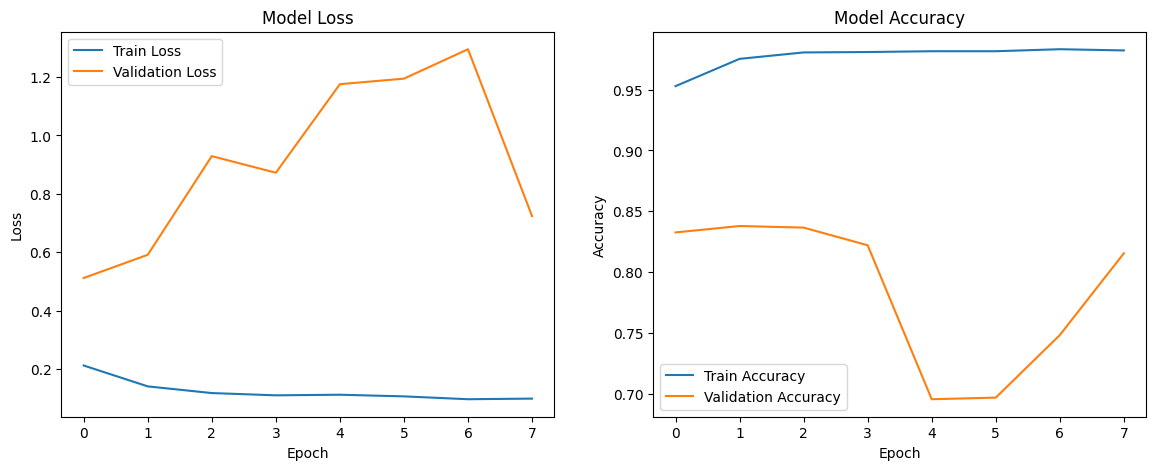

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Load the best model if not already loaded
model = load_model('best_model_gru.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Predict classes with the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(true_classes, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:\n", cm)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plotting the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#### Test the model on few samples

In [76]:
import pandas as pd
from io import StringIO
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from keras.models import load_model

# Assuming you have a saved model, or it is loaded in the environment
# model = load_model('your_model.h5')  # Uncomment this if you need to load a saved model

# Sample test dataset provided as a string
data = """Time,Command,Host IP,Destination Port
2024-04-17 23:59:42,"attack type: normal - no attack, message: left",192.168.42.170,21612
2024-04-17 23:59:43,"attack type: normal - no attack, message: left",192.168.42.170,23763
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,14590
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,49398
2024-04-17 23:59:44,"attack type: normal - no attack, message: left",192.168.42.170,107
2024-04-17 23:59:46,"attack type: normal - no attack, message: left",192.168.42.170,42565
2024-04-17 23:59:47,"attack type: normal - no attack, message: left",192.168.42.170,23304
2024-04-17 23:59:48,"attack type: normal - no attack, message: left",192.168.42.170,61682
2024-04-17 23:59:48,"attack type: normal - no attack, message: left",192.168.42.170,89
2024-04-17 23:59:50,"attack type: normal - no attack, message: down",192.168.42.170,52811
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,59632
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54185
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,9487
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,4443
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17555
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,16381
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,13309
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7582
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,43175
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25836
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31899
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,53248
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,20939
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,47986
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,5158
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,9482
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28987
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6240
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,60210
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,55941
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,61908
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,63012
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17009
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,4163
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28609
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,53544
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,62198
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,22264
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27885
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6374
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,34374
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,12472
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,36421
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17940
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25077
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,23326
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,52893
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58941
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28759
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,33891
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54179
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31845
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,50966
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,3504
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58808
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54321
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,61557
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,32792
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6162
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,20138
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54089
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27195
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,21692
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,936
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,14659
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,58794
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,56056
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,52366
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54126
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28263
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31931
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,54559
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,22016
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,21916
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,6883
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,5790
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,50546
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,48089
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2575
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,156
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,23497
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,12766
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,45216
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,49468
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41911
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,48812
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,31696
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,46776
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,37912
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,13785
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,34636
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7759
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41037
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,45997
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,41368
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,16223
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,39342
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,18436
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28357
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,14154
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27408
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,7265
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,36567
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,25706
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2540
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,29422
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,2923
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,62362
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,27782
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,17150
2024-04-17 23:59:50,"attack type: malformed packet attack, message: none",178.198.143.84,28962
2024-04-17 23:59:50,"attack type: normal - no attack, message: right",192.168.42.170,15146
2024-04-17 23:59:51,"attack type: normal - no attack, message: right",192.168.42.170,35367
2024-04-17 23:59:52,"attack type: normal - no attack, message: right",192.168.42.170,3582
2024-04-17 23:59:52,"attack type: normal - no attack, message: right",192.168.42.170,16547
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,35237
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,38717
2024-04-17 23:59:53,"attack type: normal - no attack, message: right",192.168.42.170,15430
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,8319
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,56056
2024-04-17 23:59:54,"attack type: normal - no attack, message: right",192.168.42.170,51321
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,5559
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,34640
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,8713
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,28548
2024-04-17 23:59:55,"attack type: normal - no attack, message: right",192.168.42.170,53707
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,36191
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,41405
2024-04-17 23:59:56,"attack type: normal - no attack, message: right",192.168.42.170,43101
2024-04-17 23:59:57,"attack type: normal - no attack, message: right",192.168.42.170,26153
2024-04-17 23:59:57,"attack type: normal - no attack, message: down",192.168.42.170,28812
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,27125
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,43184
2024-04-17 23:59:58,"attack type: normal - no attack, message: down",192.168.42.170,33215
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,47308
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,37442
2024-04-17 23:59:59,"attack type: normal - no attack, message: down",192.168.42.170,65220
2024-04-18 00:00:00,"attack type: normal - no attack, message: right",192.168.42.170,33697
2024-04-18 00:00:00,"attack type: normal - no attack, message: down",192.168.42.170,5578
2024-04-18 00:00:00,"attack type: normal - no attack, message: down",192.168.42.170,20373
2024-04-18 00:00:01,"attack type: normal - no attack, message: down",192.168.42.170,57539
2024-04-18 00:00:01,"attack type: normal - no attack, message: down",192.168.42.170,52870
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,8158
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,54446
2024-04-18 00:00:02,"attack type: normal - no attack, message: down",192.168.42.170,64420
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,59189
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,62554
2024-04-18 00:00:03,"attack type: normal - no attack, message: down",192.168.42.170,55307
2024-04-18 00:00:04,"attack type: normal - no attack, message: down",192.168.42.170,36370
2024-04-18 00:00:04,"attack type: normal - no attack, message: down",192.168.42.170,19998
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,34640
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,25397
2024-04-18 00:00:05,"attack type: normal - no attack, message: down",192.168.42.170,36568
2024-04-18 00:00:06,"attack type: normal - no attack, message: left",192.168.42.170,6508
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,7961
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,1020
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,49660
2024-04-18 00:00:09,"attack type: normal - no attack, message: up",192.168.42.170,47117
2024-04-18 00:00:10,"attack type: normal - no attack, message: up",192.168.42.170,61015"""

# Using StringIO to simulate reading from a file
test_data = pd.read_csv(StringIO(data))

# Extract attack types and messages
test_data['Attack Type'], test_data['Message'] = zip(*test_data['Command'].apply(lambda cmd: (cmd.split(",")[0].split(": ")[1], cmd.split(",")[1].split(": ")[1])))
test_data.drop(columns=['Command'], inplace=True)

test_t = test_data
# Convert Time to a numerical feature (e.g., timestamp)
test_t['Times'] = test_data['Time'] 
test_data['Time'] = pd.to_datetime(test_data['Time'])
test_data['Time'] = test_data['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds

# Encode categorical data and scale numerical data
encoded_features = encoder.transform(test_data[['Host IP', 'Message']]).toarray()
scaled_features = scaler.transform(test_data[['Time', 'Destination Port']])
features = np.concatenate([scaled_features, encoded_features], axis=1)

# Generate sequences for LSTM input
if len(features) >= 3:
    X_test_new = np.array([features[i:i+3] for i in range(len(features) - 2)])
    predictions = model.predict(X_test_new)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_label_names = label_encoder.inverse_transform(predictions)

    # Print predictions and ground truth
    print("\nPredictions and Ground Truth:")
    for i, (pred, idx) in enumerate(zip(predicted_label_names, range(2, len(test_data)))):
        actual = test_data['Attack Type'].iloc[idx]
        data_t = test_t['Times'].iloc[idx]
        print(f"Sequence {i+1} - Predicted: {pred}, Actual: {actual}, {data_t}")
else:
    print("Not enough data to create a sequence for the model.")


C:\Users\Rugved Chavan\AppData\Local\Temp\ipykernel_67808\3018691598.py:183: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  test_data['Time'] = test_data['Time'].view('int64') // 10**9  # convert Time to UNIX timestamp in seconds


5/5 [==============================] - 1s 3ms/step

Predictions and Ground Truth:
Sequence 1 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 2 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 3 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:44
Sequence 4 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:46
Sequence 5 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:47
Sequence 6 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:48
Sequence 7 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:48
Sequence 8 - Predicted: ['normal - no attack'], Actual: normal - no attack, 2024-04-17 23:59:50
Sequence 9 - Predicted: ['malformed packet attack'], Actual: malformed packet attack, 2024-04-17 23:59:50
Sequence 10 - Predicted: ['malformed packet 